In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

Using gpu device 1: GeForce GTX 980 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5103)


In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['mlp', 'mlp-dropout', 'mlp-bayesian', 'mlp-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name') #df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name') #df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
out_acc = ['mlp_out_classifier_auc', 'mlp-dropout_out_classifier_auc', 'mlp-bayesian_out_classifier_auc', 'mlp-poor-bayesian_out_classifier_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['mlp_in_classifier_auc', 'mlp-dropout_in_classifier_auc', 'mlp-bayesian_in_classifier_auc', 'mlp-poor-bayesian_in_classifier_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

## One way ANOVA

In [12]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.97  5.6e-4   0.04   2.91   2.95   2.97    3.0   3.05   4000    1.0
theta_free[0]     -0.13  8.3e-4   0.05  -0.23  -0.17  -0.13  -0.09  -0.03   4000    1.0
theta_free[1]      0.09  8.2e-4   0.05  -0.01   0.05   0.09   0.12   0.19   4000    1.0
sigma_likelihood   0.61  3.9e-4   0.02   0.56   0.59    0.6   0.62   0.66   4000    1.0
sigma_theta        0.63    0.03   1.68   0.04   0.12   0.23    0.5   3.85   4000    1.0
theta[0]          -0.13  8.3e-4   0.05  -0.23  -0.17  -0.13  -0.09  -0.03   4000    1.0
theta[1]           0.09  8.2e-4   0.05  -0.01   0.05   0.09   0.12   0.19   4000    1.0
theta[2]           0.04  7.6e-4   0.05  -0.05 9.9e-3   0.04   0.08   0.14   4000    1.0
lp__              

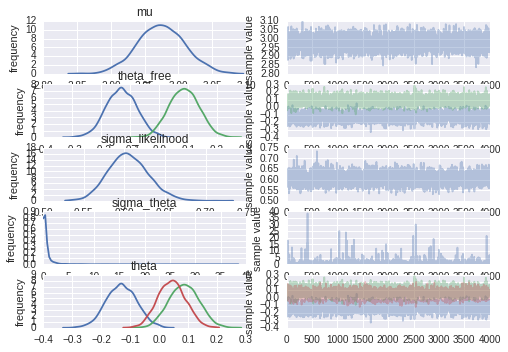

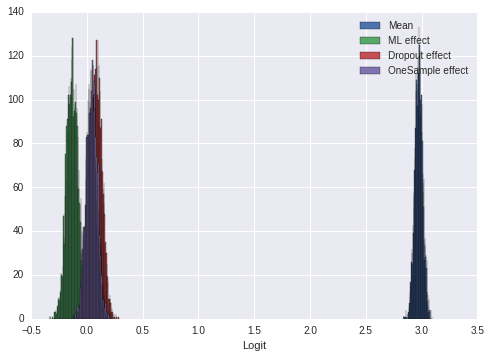

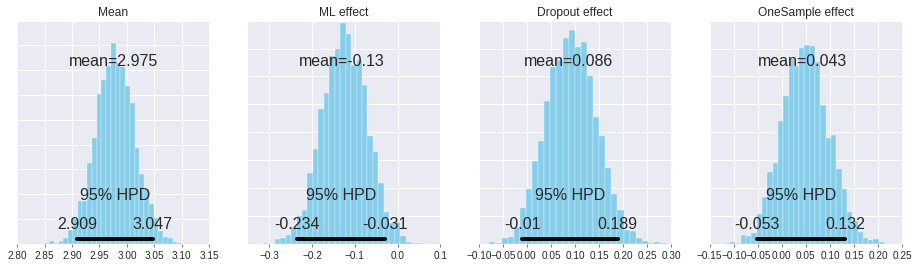

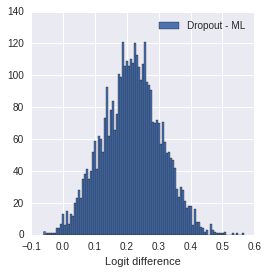

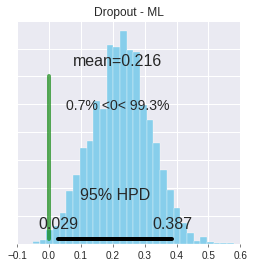

Dropout - ML 95.0 CI: 0.0377289187431 0.396752342217 Pr > 0: 0.993


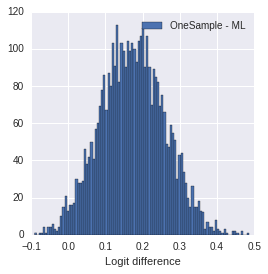

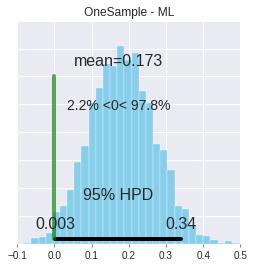

OneSample - ML 95.0 CI: 0.00516425926121 0.343888773433 Pr > 0: 0.978


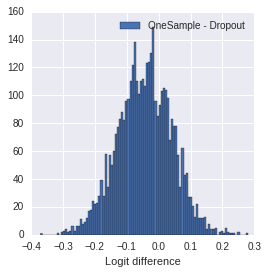

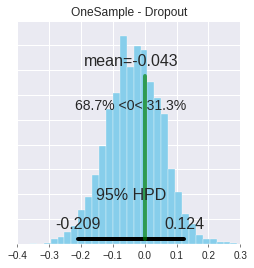

OneSample - Dropout 95.0 CI: -0.212284176864 0.121385952144 Pr > 0: 0.313


/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.17  4.5e-4   0.03   2.11   2.15   2.17   2.19   2.23   4000    1.0
theta_free[0]     -0.25  6.5e-4   0.04  -0.33  -0.27  -0.25  -0.22  -0.17   4000    1.0
theta_free[1]      0.15  6.5e-4   0.04   0.07   0.12   0.15   0.18   0.23   4000    1.0
sigma_likelihood   0.49  3.2e-4   0.02   0.46   0.48   0.49   0.51   0.54   4000    1.0
sigma_theta        1.02    0.04   2.48   0.12   0.24    0.4   0.85   6.17   4000    1.0
theta[0]          -0.25  6.5e-4   0.04  -0.33  -0.27  -0.25  -0.22  -0.17   4000    1.0
theta[1]           0.15  6.5e-4   0.04   0.07   0.12   0.15   0.18   0.23   4000    1.0
theta[2]            0.1  6.5e-4   0.04   0.02   0.07    0.1   0.13   0.18   4000    1.0
lp__              

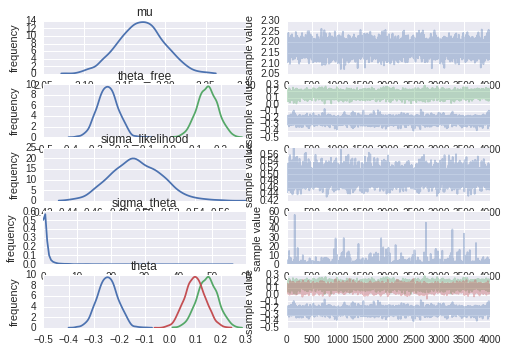

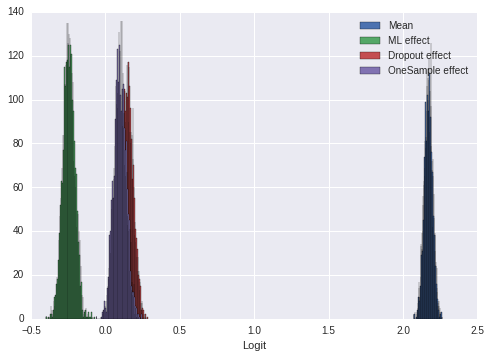

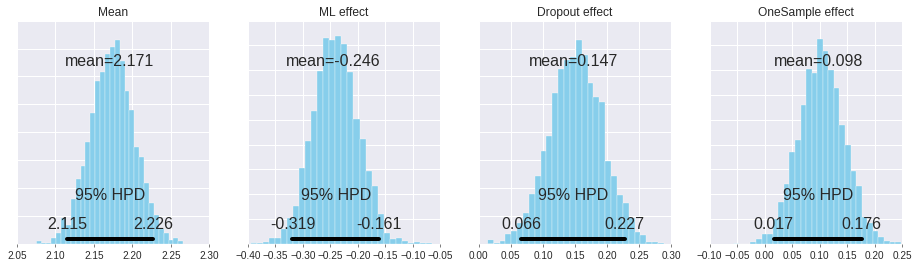

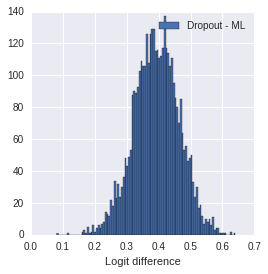

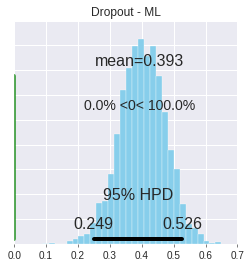

Dropout - ML 95.0 CI: 0.250660046734 0.528556538595 Pr > 0: 1.0


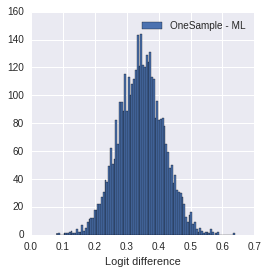

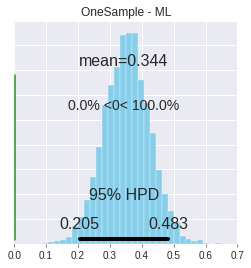

OneSample - ML 95.0 CI: 0.204898216234 0.482073228615 Pr > 0: 1.0


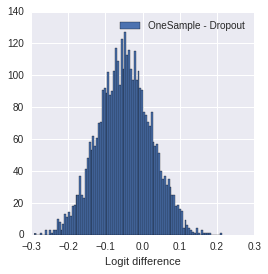

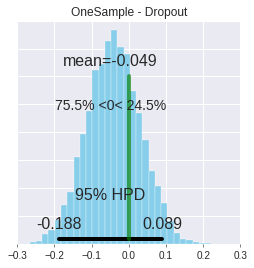

OneSample - Dropout 95.0 CI: -0.18857880067 0.0891724249758 Pr > 0: 0.24525


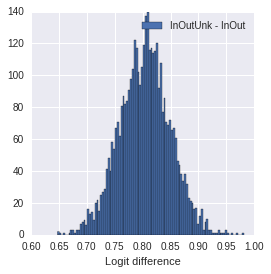

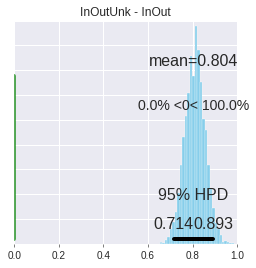

InOutUnk - InOut 95.0 CI: 0.71424335322 0.892725432701 Pr > 0: 1.0


In [14]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Mean", "ML effect", "Dropout effect", "OneSample effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')

## Two way ANOVA

In [9]:
model = pystan.StanModel(model_code=bayesian_anova.two_way_code)

/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is

Inference for Stan model: anon_model_ddea8e8a9e2bfaae4b2e9caaf410a76a.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              2.99  4.3e-4   0.03   2.93   2.97   2.99    3.0   3.04   4000    1.0
mu_out              2.2  4.4e-4   0.03   2.15   2.18    2.2   2.22   2.25   4000    1.0
theta_free[0]     -0.21  5.4e-4   0.03  -0.28  -0.23  -0.21  -0.19  -0.15   4000    1.0
theta_free[1]       0.1  5.3e-4   0.03   0.03   0.08    0.1   0.12   0.17   4000    1.0
theta_free[2]      0.06  5.2e-4   0.03-5.6e-3   0.04   0.06   0.08   0.12   4000    1.0
sigma_likelihood   0.55  2.2e-4   0.01   0.52   0.54   0.55   0.56   0.58   4000    1.0
sigma_theta         0.3  5.6e-3   0.35   0.09   0.14   0.21   0.33   1.12   4000    1.0
theta[0]          -0.21  5.4e-4   0.03  -0.28  -0.23  -0.21  -0.19  -0.15   4000    1.0
theta[1]          

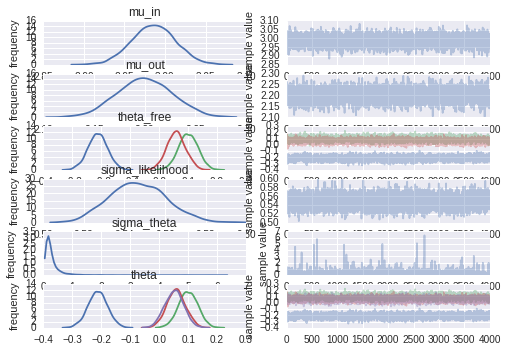

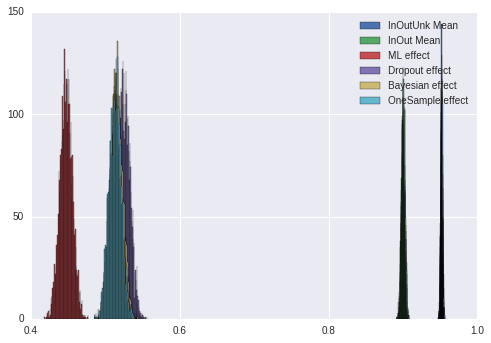

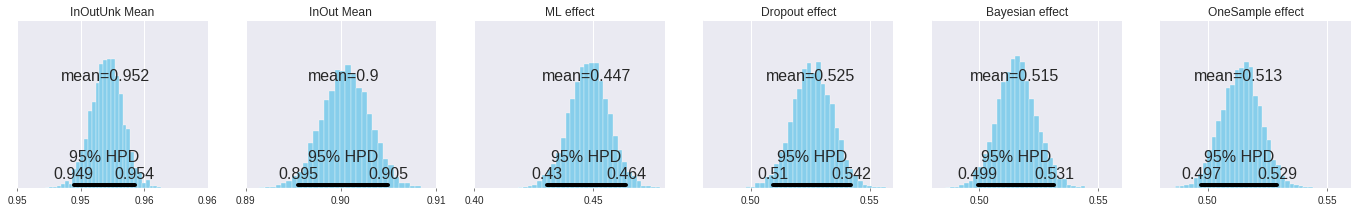

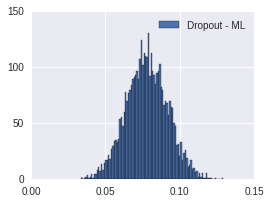

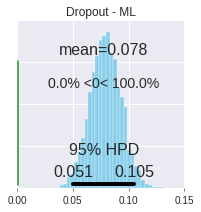

Dropout - ML 95.0 CI: 0.050629330895 0.104905086066 Pr > 0: 1.0


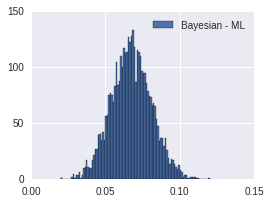

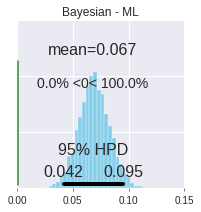

Bayesian - ML 95.0 CI: 0.0413319057256 0.0946196742639 Pr > 0: 1.0


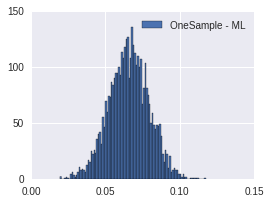

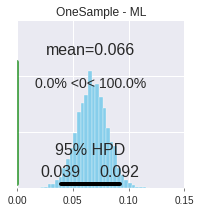

OneSample - ML 95.0 CI: 0.0389947113745 0.0916709215654 Pr > 0: 1.0


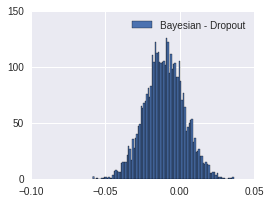

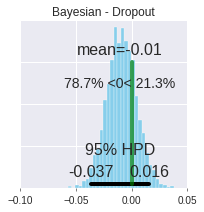

Bayesian - Dropout 95.0 CI: -0.0364206568181 0.0158389228157 Pr > 0: 0.213


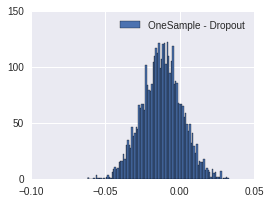

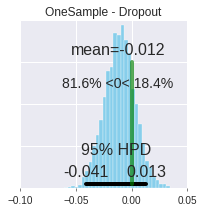

OneSample - Dropout 95.0 CI: -0.0390279188493 0.0151600655451 Pr > 0: 0.184


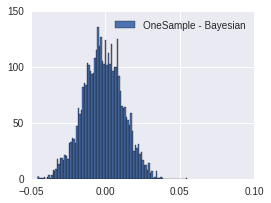

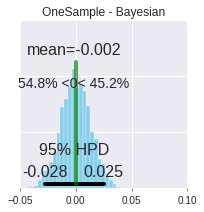

OneSample - Bayesian 95.0 CI: -0.0290257597462 0.0242181874795 Pr > 0: 0.4515


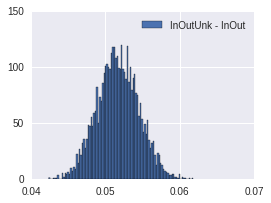

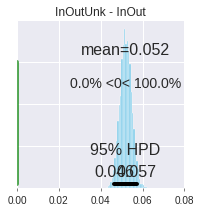

InOutUnk - InOut 95.0 CI: 0.0463741803059 0.0571543361852 Pr > 0: 1.0


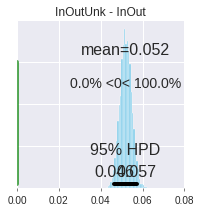

In [11]:
(N, K) = y_in.shape
data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model.sampling(data=data, iter=10000, chains=4, thin=5)

bayesian_anova.show_results(fit)

trace = fit.extract()
deterministic = scipy.special.expit(trace['theta'][:,0])
dropout = scipy.special.expit(trace['theta'][:,1])
bayesian = scipy.special.expit(trace['theta'][:,2])
poor_bayesian = scipy.special.expit(trace['theta'][:,3])
in_mean = scipy.special.expit(trace['mu_in'])
out_mean = scipy.special.expit(trace['mu_out'])

bayesian_anova.plot_traces([in_mean, out_mean, deterministic, dropout, bayesian, poor_bayesian],
                           ["InOutUnk Mean", "InOut Mean", "ML effect", "Dropout effect", "Bayesian effect", "OneSample effect"])

bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
bayesian_anova.effect_difference(bayesian, deterministic, 'Bayesian', 'ML')
bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
bayesian_anova.effect_difference(bayesian, dropout, 'Bayesian', 'Dropout')
bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')
bayesian_anova.effect_difference(poor_bayesian, bayesian, 'OneSample', 'Bayesian')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')